### 一.损失函数

这一节对xgboost回归做介绍，xgboost共实现了5种类型的回归，分别是squarederror、logistic、poisson、gamma、tweedie回归，下面主要对前两种进行推导实现，剩余三种放到下一节  

#### squarederror
即损失函数为平方误差的回归模型：  

$$
L(y,\hat{y})=\frac{1}{2}(y-\hat{y})^2
$$  

所以一阶导和二阶导分别为：   

$$
\frac{\partial L(y,\hat{y})}{\partial \hat{y}}=\hat{y}-y\\
\frac{\partial^2 L(y,\hat{y})}{{\partial \hat{y}}^2}=1.0\\
$$  

#### logistic

由于是回归任务，所以y也要套上`sigmoid`函数（用$\sigma(\cdot)$表示），损失函数：   

$$
L(y,\hat{y})=(1-\sigma(y))log(1-\sigma(\hat{y}))+\sigma(y)log(\sigma(\hat{y}))
$$

一阶导和二阶导分别为：   

$$
\frac{\partial L(y,\hat{y})}{\partial \hat{y}}=\sigma(\hat{y})-\sigma(y)\\
\frac{\partial^2 L(y,\hat{y})}{{\partial \hat{y}}^2}=\sigma(\hat{y})(1-\sigma(\hat{y}))\\
$$   


### 二.代码实现
具体流程与gbdt的回归类似，只是每次要计算一阶、二阶导数信息，同时基学习器要替换为上一节的xgboost回归树

In [1]:
import os
os.chdir('../')
import matplotlib.pyplot as plt
%matplotlib inline
from ml_models.ensemble import XGBoostBaseTree
from ml_models import utils
import copy
import numpy as np

"""
xgboost回归树的实现，封装到ml_models.ensemble
"""

class XGBoostRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, learning_rate=1.0, loss='squarederror'):
        """
        :param base_estimator: 基学习器
        :param n_estimators: 基学习器迭代数量
        :param learning_rate: 学习率，降低后续基学习器的权重，避免过拟合
        :param loss:损失函数，支持squarederror、logistic
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = XGBoostBaseTree()
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)
        self.loss = loss

    def _get_gradient_hess(self, y, y_pred):
        """
        获取一阶、二阶导数信息
        :param y:真实值
        :param y_pred:预测值
        :return:
        """
        if self.loss == 'squarederror':
            return y_pred - y, np.ones_like(y)
        elif self.loss == 'logistic':
            return utils.sigmoid(y_pred) - utils.sigmoid(y), utils.sigmoid(y_pred) * (1 - utils.sigmoid(y_pred))

    def fit(self, x, y):
        y_pred = np.zeros_like(y)
        g, h = self._get_gradient_hess(y, y_pred)
        for index in range(0, self.n_estimators):
            self.base_estimator[index].fit(x, g, h)
            y_pred += self.base_estimator[index].predict(x) * self.learning_rate
            g, h = self._get_gradient_hess(y, y_pred)

    def predict(self, x):
        rst_np = np.sum(
            [self.base_estimator[0].predict(x)] +
            [self.learning_rate * self.base_estimator[i].predict(x) for i in
             range(1, self.n_estimators - 1)] +
            [self.base_estimator[self.n_estimators - 1].predict(x)]
            , axis=0)
        return rst_np

In [2]:
from sklearn.datasets import load_boston
dataset = load_boston()
data = dataset.data
target = dataset.target

C:\Users\QR_Zh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [4]:
xgr = XGBoostRegressor()
xgr.fit(data,target)
pred = xgr.predict(data)

In [5]:
pred

array([24.04160316, 21.66934895, 34.79069003, 33.42726973, 36.22756701,
       28.65984973, 22.94723739, 27.04502798, 16.58823639, 18.77005457,
       14.98921602, 18.84973198, 21.66166827, 20.39269496, 18.27804686,
       19.91696764, 23.01295398, 17.44731935, 20.1796217 , 18.13727166,
       13.59520914, 19.59488918, 15.12984898, 14.53030356, 15.63162205,
       13.84664665, 16.5776578 , 14.76621261, 18.3772974 , 20.9486218 ,
       12.74699902, 14.58789563, 13.15232533, 13.11063538, 13.52508157,
       18.897782  , 19.94870233, 20.99698429, 24.74942141, 30.84060385,
       34.88776421, 26.60324036, 25.30572704, 24.61156496, 21.19078841,
       19.37077324, 19.96627928, 16.6945302 , 14.44505404, 19.28822098,
       19.69422762, 20.61806159, 25.05522957, 23.41321002, 18.89002416,
       35.38967255, 24.72459928, 31.60347191, 23.33617533, 19.55644153,
       18.69631291, 16.06275912, 22.24629978, 24.98646674, 32.97177832,
       23.46691334, 19.34461972, 21.96081926, 17.29694822, 20.93

In [2]:
#测试
data = np.linspace(1, 10, num=100)
target = np.sin(data) + np.random.random(size=100)  # 添加噪声
data = data.reshape((-1, 1))

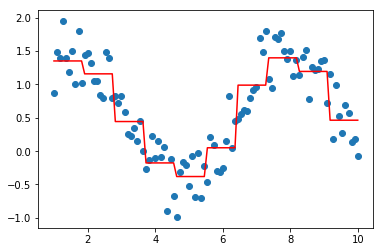

In [3]:
model = XGBoostRegressor(loss='squarederror')
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()

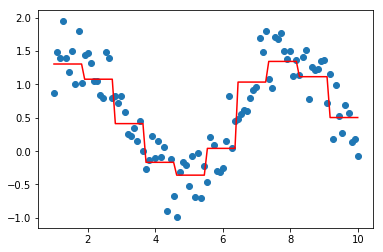

In [4]:
model = XGBoostRegressor(loss='logistic')
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()